<div style="text-align: right"><b> Camilo Andrés Gomez Vargas & Paula Lorena Lopez Romero. </b></div>

## Proyecto II: Segmentación Morfológica 

## Introducción
Las operaciones morfológicas nos permiten hacer cambios en el tamaño, forma, conectividad y color de las imagenes con el fin de tener obtener una transformación más detallada de sus características.

El presente proyecto busca desarrollar un algoritmo que segmente la imagen de una célula de planta en regiones que represeten diferente granulación. Para ello, se implementarán operaciones morfologicas que se han visto a lo largo de las clases. 


Importamos las librerías que utilizaremos a lo largo del proyecto.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Definimos las funciones morfológicas de `erosion`, `dilatacion`, `opening` y `top_hat`.

In [2]:
def plot_images(original, filtered):
    fig, ax = plt.subplots(1,2, figsize=(15,15))
    ax[0].imshow(original, cmap = 'gray')
    ax[0].set_title('Imagen original')
    ax[1].imshow(filtered)
    ax[1].set_title('Imagen final')

El algortimo de `erosión` tiende a contrastar las regiones más oscuras de la imagen. Esto se da porque el algoritmo elimina el ruido de los bordes de la imagen a tratar.

In [3]:
def erosion(img, kernel):
    matrix = np.zeros(img.shape)
    image = cv2.copyMakeBorder(img, kernel.shape[0], kernel.shape[0], kernel.shape[1], kernel.shape[1], cv2.BORDER_REFLECT)
    for n in range(img.shape[0]-1):
        for m in range(img.shape[1]-1):
            A = image[n:n+kernel.shape[0], m:m+kernel.shape[1]] 
            kernel_vals = [qq for q in kernel.tolist() for qq in q]
            vals_min = [qq for q in np.multiply(A, kernel).tolist() for qq in q]
            vals_min = [vals_min[idx] for idx in range(len(vals_min)) if kernel_vals[idx] == 1]
            if len(vals_min) == 0:
                vals_min = [0]
            val = min(vals_min)
            matrix[n,m] = val
    return matrix

El algoritmo de `dilatacion` expande los blancos. Es decir, elimina los bordes más finos para tener una imagen más clara.

In [4]:
def dilatacion(img, kernel):
    matrix = np.zeros(img.shape)
    image = cv2.copyMakeBorder(img, kernel.shape[0], kernel.shape[0], kernel.shape[1], kernel.shape[1], cv2.BORDER_REFLECT)
    for n in range(img.shape[0]-1):
        for m in range(img.shape[1]-1):
            A = image[n:n+kernel.shape[0], m:m+kernel.shape[1]] 
            kernel_vals = [qq for q in kernel.tolist() for qq in q]
            vals_max = [qq for q in np.multiply(A, kernel).tolist() for qq in q]
            vals_max = [vals_max[idx] for idx in range(len(vals_max)) if kernel_vals[idx] == 1]
            if len(vals_max) == 0:
                vals_max = [0]
            val = max(vals_max)
            matrix[n,m] = val
    return matrix

El algortimo de `opening` busca eliminar las zonas mas estrechas dependiendo del elemento estructural. Esto quiere decir que expande los huecos para que sean más marcados.

In [5]:
def opening(image, kernel):
    img_erosion = erosion(image, kernel)
    img_opening = dilatacion(img_erosion, kernel)
    return img_opening

El algortimo de `top_hat`, busca resolver los problemas de luminosidad y ruido de la imagen

In [6]:
def top_hat(img, kernel):
    matrix = img - opening(img, kernel)
    matrix[np.where(matrix<0)] = 0
    return matrix

Creamos una función `color`, la cual recibe la imagen, el elemento estructural de transformación y un color en escala _RGB_.

Como la imagen está en blanco y negro, al hacerle `opening`, esta tiende a resaltar las características oscuras. Así pues, hallamos la diferencia entre la imagen original y el resultado de la anterior operación, con el fin de obtener los valores que dado el resultado aumentaron.

Además, hallamos la media de la diferencia para definir el valor del umbral. Este umbral nos permite hacer una segmentación de los pixeles de la  imagen en dos categorías: color asignado y negro.

In [7]:
def color(img, kernel, lst):
    img_opening = opening(img, kernel)
    diff = cv2.absdiff(img, img_opening.astype(np.uint8))
    mean_diff = int(np.mean(diff))
    resultrgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    resultrgb[diff>mean_diff] = (lst[0], lst[1], lst[2])
    return resultrgb

La función `segmentacion` recibe como parámetros la imagen, una lista de colores en escala _RGB_ y una lista con los diferentes elementos esctructurales con los que se hará la extracción de las diferentes texturas de la imagen.

De esta manera, la función retornará diferentes imágenes acordes a diferentes elementos estructurales, que además, están ligadas a diferentes colores para realizar la segmentación final. 

In [8]:
def segmentacion(img, lst_color, lst_kernel):
    result = []
    for i in range(len(lst_kernel)):
        color_ = color(img,lst_kernel[i],lst_color[i])
        result.append(color_)
    return result

Creamos el elemento estructural base con el cual se realizarán todas las operaciones.

In [9]:
kernel = np.array([[0, 0, 1, 0, 0], 
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [0, 0, 1, 0, 0]])

Importamos la imagen con la que trabajaremos.

In [10]:
celula = cv2.imread('img/planta_celula.png')
img_celula = cv2.cvtColor(celula, cv2.COLOR_BGR2GRAY)

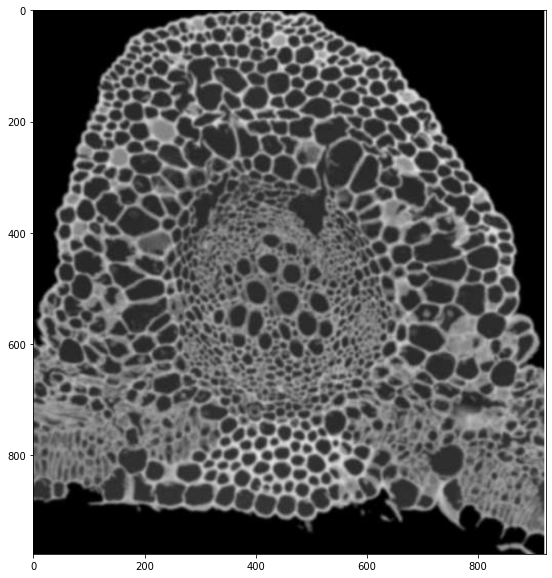

In [11]:
plt.figure(figsize=(15,10))
plt.imshow(img_celula, cmap='gray')

Utilizamos `top_hat` con el fin de corregir la iluminación y obtener los detalles de los bordes de la imagen original.


In [12]:
top_img = top_hat(img_celula, kernel)

Note que, la lista de color debe ser igual a la lista de los elementos estructurales. En este caso seleccionamos los elementos estructurales de radio `[5, 12, 20]` dado que se tiene en cuenta el principal elemento estructural.

In [13]:
colors = [[255, 0, 0],[255, 120, 255], [100, 80, 255]]
lst_kernel = []
kns = [0, 7, 15]
for n in kns:
    krn = cv2.copyMakeBorder(kernel, n, n, n, n, cv2.BORDER_REFLECT)
    lst_kernel.append(krn)

Realizamos la segmentación.

In [14]:
seg = segmentacion(img_celula, colors, lst_kernel)

Note que el elemento estructural del menor tamaño contiene la textura más fina. Esto se puede observar en el centro de la imagen y en los bordes donde se encuentran los diferentes huecos de la imagen.

Por otro lado, note que el elemento estructural de mayor tamaño tiene mayor definción en las texturas gruesas. Esto se puede observar en la textura entre el centro y los  bordes donde se encuentran los huecos de mayor tamaño.

In [15]:
stack = np.hstack((seg[0], seg[2]))

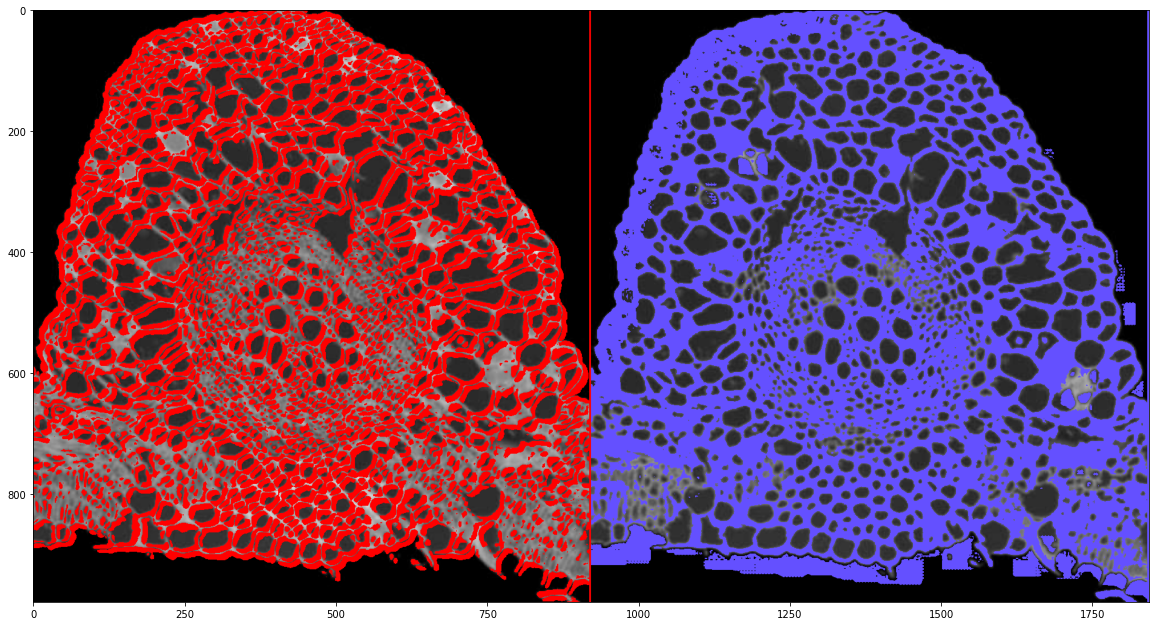

In [16]:
plt.figure(figsize=(20,11))
plt.imshow(stack)

La capa final será la imagen filtrada con `top_hat` en otro tono de color con el fin de diferenciar más la segmentación. 

In [17]:
capa_final = np.dstack((1-top_img, 200-top_img, top_img))
capa_final = capa_final.astype(np.uint8)

Si la sobreponemos a la segmentación total, tendremos una imagen final clara.

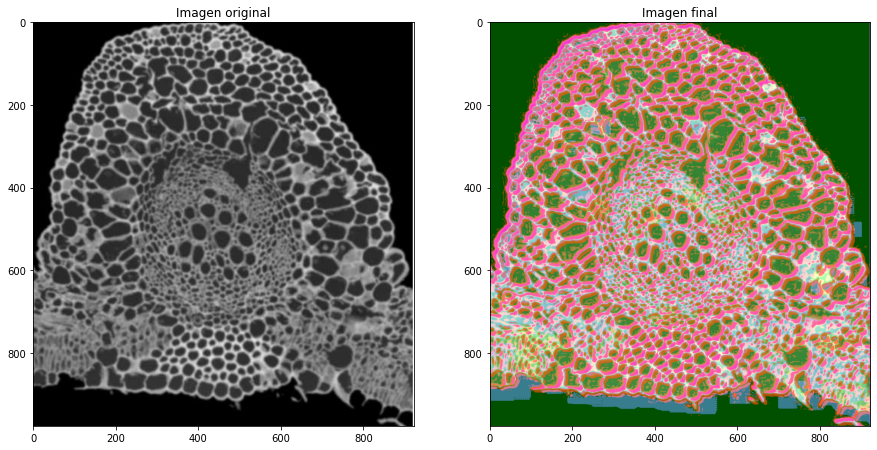

In [18]:
seg_final = cv2.addWeighted(seg[0],0.8, seg[2], 0.7,0)
seg_final = cv2.addWeighted(seg_final, 0.8, capa_final, 0.4,0)
plot_images(img_celula, seg_final)

## Conclusiones: 
- Podemos evidenciar que las regiones de color verde son las texturas que el algortimo identifica como grandes. Las más pequeñas están de color azul claro y verde claro. Mientras que los bordes están en color rosado. Esto se debe a que el algoritmo identificó el color blanco en la imagen original como una textura.

- En la segmentación de imágenes es importante identificar la composición de la imagen. De esta manera, se puede definir con cuales operaciones morfológicas se obtendrán mejores resultados.

- Las operaciones morfológicas son una buena herrramienta para la extracción de las características de una imagen, identificando las diferentes texturas distorsionadas o ruidosas.

## Observaciones:
- Implementar los algoritmos de una manera más eficiente computacionalmente  y que no consuma tanto almacenamiento.
- Definir los elementos estructurales de una manera más genérica.
- Identificar de manera más precisa las texturas de la imagen de tal forma que, no se añadan nuevas texturas o no se identificquen texturas inexistentes.

<div style="text-align: right"><b> Camilo Andrés Gomez Vargas & Paula Lorena Lopez Romero. </b></div>